In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import importlib
import dataReading 
import sympy as sp 
from scipy.optimize import minimize
from functools import partial
from scipy.stats import norm, t
from statsmodels.graphics.gofplots import qqplot
from statsmodels import distributions
import statsmodels.api as sm


In [60]:
# How to load all functions from a file into the notebook
importlib.reload(dataReading) # Needed so that you dont need to reload kernel when changing function
from dataReading import *

## Lab 1 Enterprise Risk Management

## 1. Daily volatility forecast using MA and EWMA

Perform a daily volatility forecast using MA and EWMA with a 60 day estimation window, over the time period
2020-01-01 -> 2023-12-31 for the Nasdaq 100 index (^NDX). Plot the daily forecasts in the same plot. 
Plot also the log-returns in a separate plot below.

*Discussion: What is the main reason for the differences in these two forecasts.*

The moving average forecast puts equal weight on all observations in the estimation period. In our case this means that the square returns observed 60 days ago has the same weight as the one seen yesterday. This is in contrast to the exponentially weighted moving average forecast which puts less and less weights on observations the longer ago they were observed. This makes it so that the EWMA better captures the autocorrelation of the square returns and hence becomes more reactive to recent events. 

In [61]:
### To download data and store it as a csv file in the folder DataFileFolder. The filename is price_<TICKER>
# ticker = '^NDX'
# startDate = '2020-01-01'
# endDate = '2023-12-31'
# stockData = readDataFromYahoo(ticker, startDate, endDate)

# fileName = saveDataToCsv(stockData = stockData, stockName = ticker)

In [62]:
# To download data from file
stockDataFromFile = readDataFromFile('price_^NDX.csv')
price = stockDataFromFile[['Close']]

price['logReturns'] = np.log(price).diff()
price['squarePrice'] = price['logReturns'] ** 2
#logReturns = np.log(price).diff().dropna()
#logReturns['squarePrice'] = logReturns['Close'] ** 2
price = price.dropna() 
price.head()


C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\4168434398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['logReturns'] = np.log(price).diff()
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\4168434398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['squarePrice'] = price['logReturns'] ** 2


,Close,logReturns,squarePrice
Date,,,
2020-01-03 00:00:00-05:00,8793.900391,-0.008867,7.861788e-05
2020-01-06 00:00:00-05:00,8848.519531,0.006192,3.833859e-05
2020-01-07 00:00:00-05:00,8846.450195,-0.000234,5.470441e-08
2020-01-08 00:00:00-05:00,8912.370117,0.007424,5.511491e-05
2020-01-09 00:00:00-05:00,8989.629883,0.008631,7.450219e-05


In [63]:
T = 60
volatilityEstimateMA = np.zeros(price.shape[0]-T)

for i in range(len(volatilityEstimateMA)):
    volatilityEstimateMA[i] = np.sqrt( np.mean( price.iloc[i:(i+T)]['squarePrice']))



In [64]:
volatilityEstimateEWMA = np.zeros(price.shape[0]-T)
initialVolatility = np.sqrt(np.mean( price.iloc[0:T]['squarePrice']))
lambdaValue = 0.94

for i in range(len(volatilityEstimateEWMA)):
    volatilityEstimateEWMA[i] = np.sqrt( (1-lambdaValue) *  price.iloc[(i+T)]['squarePrice'] + lambdaValue* initialVolatility ** 2)
    initialVolatility = volatilityEstimateEWMA[i]


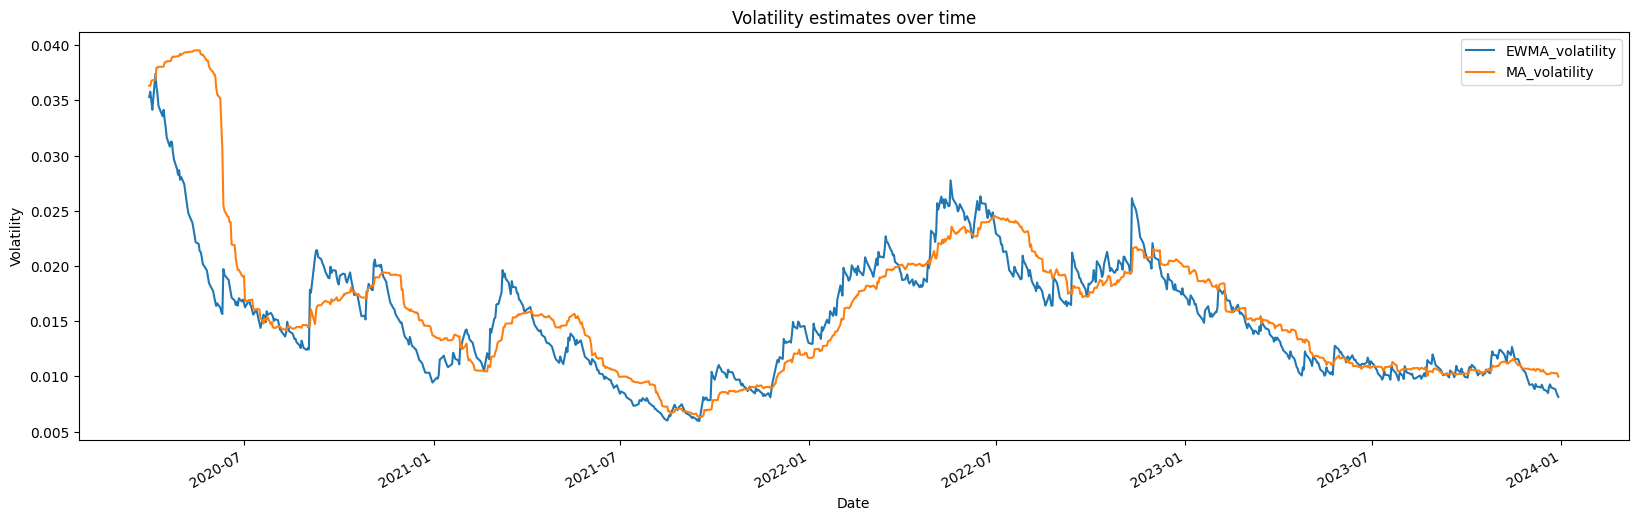

In [65]:
volatilityDf = price.iloc[T:][['Close', 'logReturns']]
volatilityDf['MA_volatility'] = volatilityEstimateMA
volatilityDf['EWMA_volatility'] = volatilityEstimateEWMA

volatilityDf[['EWMA_volatility','MA_volatility']].plot(title = 'Volatility estimates over time', ylabel='Volatility', figsize=(20,6) );

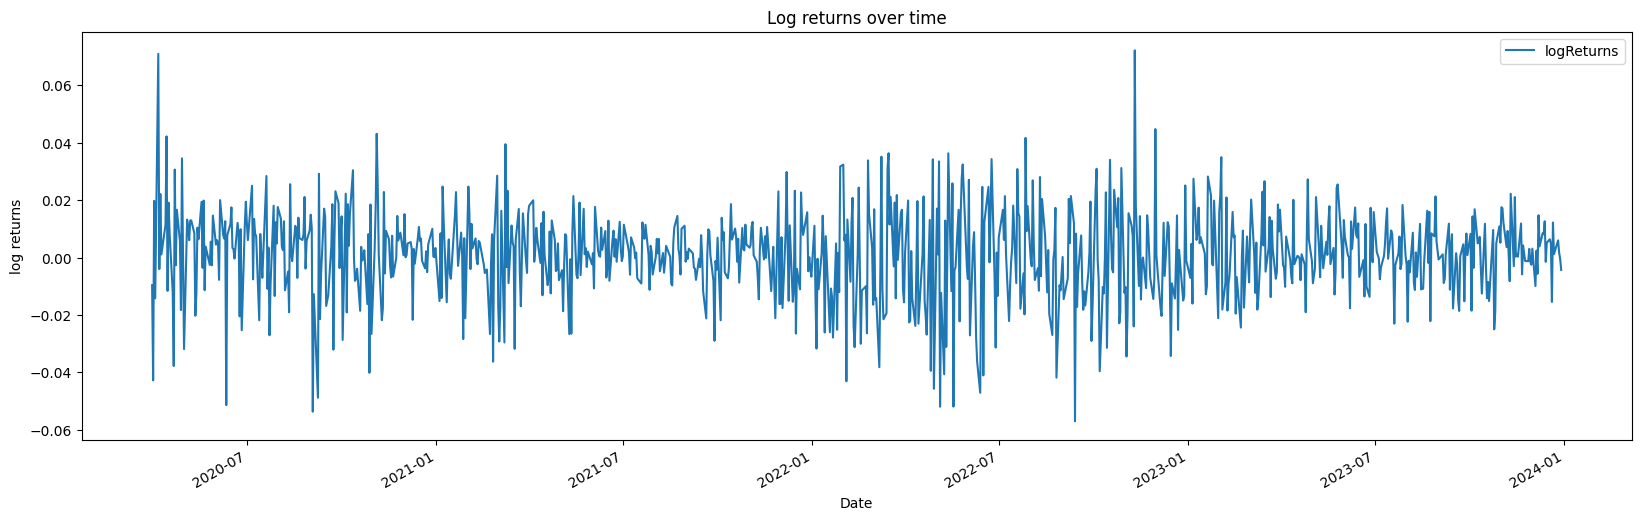

In [66]:
volatilityDf[['logReturns']].plot(title = 'Log returns over time', ylabel = 'log returns', figsize=(20,6));

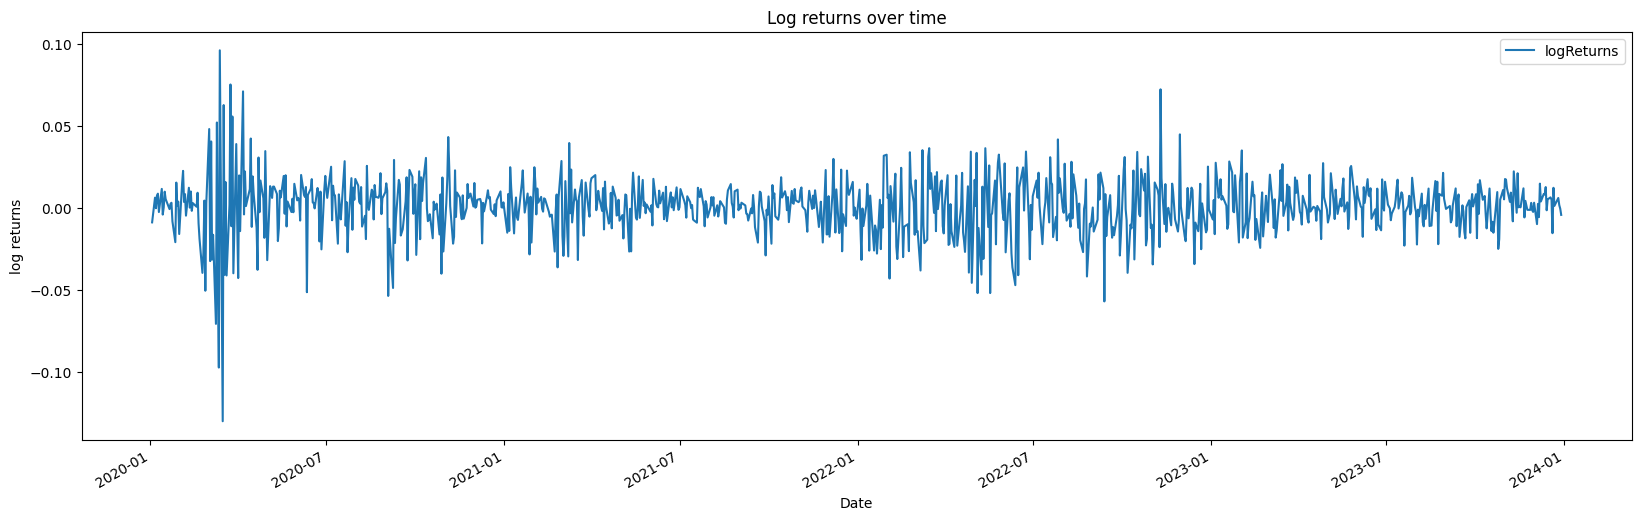

In [67]:
price[['logReturns']].plot(title = 'Log returns over time', ylabel = 'log returns', figsize=(20,6));

## 2. Daily volatility forecast using GARCH

Fit a GARCH(1,1)-model using Nasdaq return data for the time period 2010-01-01 -> 2019-12-31 and then
perform a daily volatility forecast as in 1, with forecasting period: 2020-01-01 -> 2023-12-31. Plot your daily
forecast in the same plot as in 1.

*Discussion: What is the main reason for the difference between the GARCH and the EWMA forecast.*

The main difference between GARCH and EWMA is that GARCH gives the volatility estimate a floor so that it can not go under the long term volatility level. 

In [68]:
### To download data and store it as a csv file in the folder DataFileFolder. The filename is price_<TICKER>
# ticker = '^NDX'
# startDate = '2010-01-01'
# endDate = '2023-12-31'
# stockData = readDataFromYahoo(ticker, startDate, endDate)

# fileName = saveDataToCsv(stockData = stockData, stockName = ticker)

In [69]:
# To download data from file
stockDataFromFile = readDataFromFile('price_^NDX_2024-09-10.csv')
price = stockDataFromFile[['Close']]

price['logReturns'] = np.log(price).diff()
price['squarePrice'] = price[['logReturns']] ** 2
price['multipliedSqPrice'] = (100 * price[['logReturns']]) ** 2
#logReturns = np.log(price).diff().dropna()
#logReturns['squarePrice'] = logReturns['Close'] ** 2
price = price.dropna() 
price.head()

splitDate = pd.Timestamp('2020-01-01', tz='UTC')

# Spliting DataFrame into estimation and testing period 
estimationPeriod = price[price.index < splitDate]
testPeriod = price[price.index >= splitDate]

C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\1297075775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['logReturns'] = np.log(price).diff()
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\1297075775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['squarePrice'] = price[['logReturns']] ** 2
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\1297075775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [70]:
# ## Parameter estimation
# def likelihoodFunction(dataFrame, omega, alpha, beta):
#     initialVolatility = np.std(dataFrame['multipliedSqPrice']) # Not the same variance as in task 1 ???

#     volatilityVector = np.zeros(len(dataFrame))
#     volatilityVector[0] = initialVolatility
#     terms = np.zeros(len(dataFrame)-1)

#     for i in range(1, len(dataFrame)):
#         volatilityVector[i] = np.sqrt(omega + alpha * float(dataFrame.iloc[i-1]['multipliedSqPrice'])  + beta * volatilityVector[i-1] ** 2)
#         terms[i-1] = np.log(volatilityVector[i] ** 2) + float(dataFrame.iloc[i]['multipliedSqPrice']) / (volatilityVector[i] ** 2)
        
#     likelihood = -1/2 * (sum(terms))
#     return likelihood


# omega = np.linspace(0.001, 0.01,15)
# alpha = np.linspace(0.01, 0.15,15)
# beta = np.linspace(0.85, 0.9, 15)

# OMEGA, ALPHA, BETA = np.meshgrid(omega, alpha, beta)


# likelihood = np.zeros(OMEGA.shape)

# for i in range(OMEGA.shape[0]):
#     for j in range(OMEGA.shape[1]):
#         for k in range(OMEGA.shape[2]):
#             if (ALPHA[i,j,k] + BETA[i,j,k] >= 1):
#                 break

#             likelihood[i,j,k] = likelihoodFunction(estimationPeriod, OMEGA[i,j,k], ALPHA[i,j,k], BETA[i,j,k])


In [71]:
# ## Find best point

# np.max(likelihood)
# maxValue = np.max(likelihood[likelihood != 0])
# maxIndex = np.unravel_index(np.argmax(likelihood == maxValue), likelihood. shape)

# print('Index for max value and max value')
# print(maxIndex, maxValue)

# valuesOfParameters = (OMEGA[maxIndex]/100**2, ALPHA[maxIndex], BETA[maxIndex])
# print('Values of (omega, alpha, beta)')
# print(valuesOfParameters)

# print(valuesOfParameters[0]*100**2)

In [72]:
## Using Scipy
def likelihoodFunction( parameters, dataFrame):
    omega = parameters[0]
    alpha = parameters[1]
    beta = parameters[2]
    initialVolatility = np.std(dataFrame['multipliedSqPrice']) # Not the same variance as in task 1 ???

    volatilityVector = np.zeros(len(dataFrame))
    volatilityVector[0] = initialVolatility
    terms = np.zeros(len(dataFrame)-1)

    for i in range(1, len(dataFrame)):
        volatilityVector[i] = np.sqrt(omega + alpha * float(dataFrame.iloc[i-1]['multipliedSqPrice'])  + beta * volatilityVector[i-1] ** 2)
        terms[i-1] = np.log(volatilityVector[i] ** 2) + float(dataFrame.iloc[i]['multipliedSqPrice']) / (volatilityVector[i] ** 2)
        
    likelihood = -1/2 * (sum(terms))
    return -likelihood

epsilon = 1e-10
constraints = [{'type': 'ineq', 'fun': lambda parameters: -(parameters[1] +parameters[2] -1 -epsilon)}]
bounds = [(0 + epsilon, None), (0 + epsilon, None), (0 + epsilon, None)] #omega, alpha, beta

x0 = [0.05, 0.12, 0.83]
objectiveFixDF = partial(likelihoodFunction, dataFrame = estimationPeriod)
result = minimize(objectiveFixDF, x0, method='SLSQP', bounds=bounds, constraints=constraints )

print("Optimal parameters:", result.x)
print("Function value at the optimum:", result.fun)

C:\Users\Bolli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimal parameters: [0.05401792 0.1221255  0.83115234]
Function value at the optimum: 1230.4995832071547


In [73]:
# ## Volatility estimation

## Scipy parameters
omega =  result.x[0]/(100**2) 
alpha = result.x[1] 
beta =  result.x[2] 

## Grid parameters
# omega =  valuesOfParameters[0]
# alpha = valuesOfParameters[1]
# beta =  valuesOfParameters[2]

volatilityEstimateGARCH = np.zeros(testPeriod.shape[0])
#initialVolatility = np.sqrt(np.mean( estimationPeriod['squarePrice']))
initialVolatility = np.sqrt(np.var( estimationPeriod['logReturns']))

volatilityEstimateGARCH[0] = initialVolatility 

for i in range(0, len(volatilityEstimateGARCH)):
    volatilityEstimateGARCH[i] = np.sqrt(omega + alpha *  testPeriod.iloc[i]['squarePrice'] +  beta * (initialVolatility ** 2))
    initialVolatility = volatilityEstimateGARCH[i]

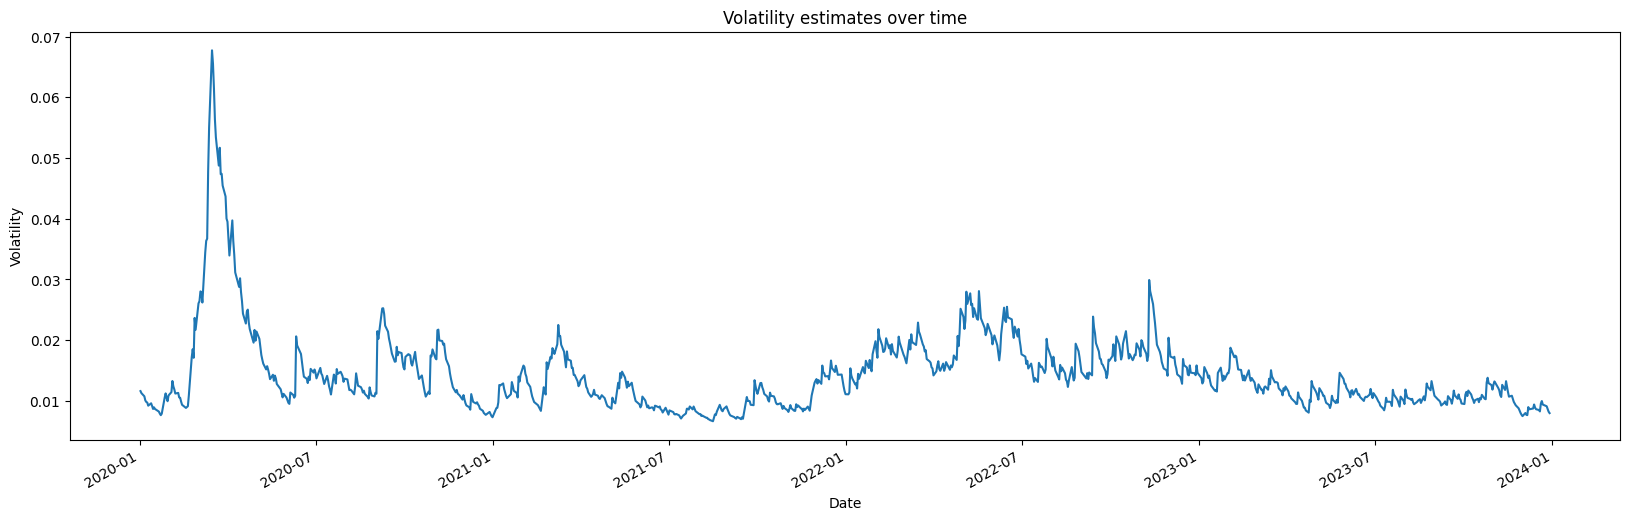

In [74]:
volatilityDfGRACH = testPeriod[['Close', 'logReturns']].copy()
volatilityDfGRACH.loc[:, 'GARCH_volatility'] = volatilityEstimateGARCH
volatilityDfGRACH['GARCH_volatility'].plot(title = 'Volatility estimates over time', ylabel='Volatility', figsize=(20,6) );

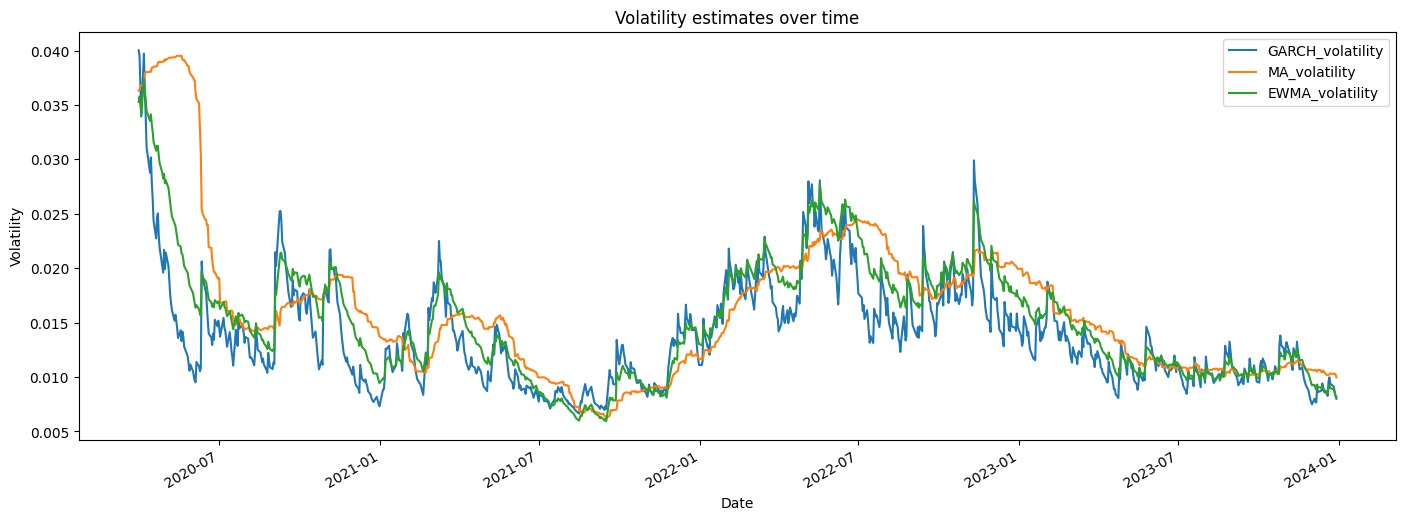

In [75]:
volDF = volatilityDf[['Close', 'logReturns', 'MA_volatility', 'EWMA_volatility']].copy()
volDF['GARCH_volatility'] = volatilityEstimateGARCH[T+1:]

#volDF['GARCH_volatility_package'] = volatilityEstimateGARCH[T+1:]

volDF[['GARCH_volatility', 'MA_volatility', 'EWMA_volatility']].plot(title = 'Volatility estimates over time', ylabel='Volatility', figsize=(17,6));


## 3. GARCH model diagnostics

Analyze the GARCH-model and perform model diagnostics:
- a) What are the GARCH-parameters and what is the unconditional volatility?
- b) Plot the ACF (for lags 1 to 200) for the returns and the squared returns (use a stem-plot).
- c) Plot the ACF (for lags 1 to 200) for the residuals and the squared residuals (use a stem-plot).
- d) Plot a histogram (using 100 bins) of the residuals together with a normal pdf (same mean and std).
- e) QQ-plot the residuals against normal- and student t quantiles. What t-distribution provides the best fit
to the left tail?

*Discussion: What does b) and c) tell you? What does d), e) and f) tell you?*

In [76]:
## a) Unconditional volatility
print(f'Omega = {omega:.3f}')
print(f'Alpha = {alpha:.3f}')
print(f'Beta = {beta:.3f}')
# Alpha
# Beta


unconditionalVol = np.sqrt(omega/(1-(alpha+beta))*252)
print(f'Unconditional volatility: {unconditionalVol:.3f}' )

Omega = 0.000
Alpha = 0.122
Beta = 0.831
Unconditional volatility: 0.171


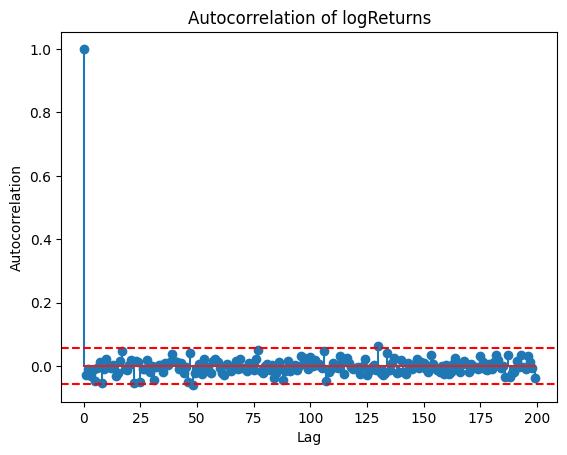

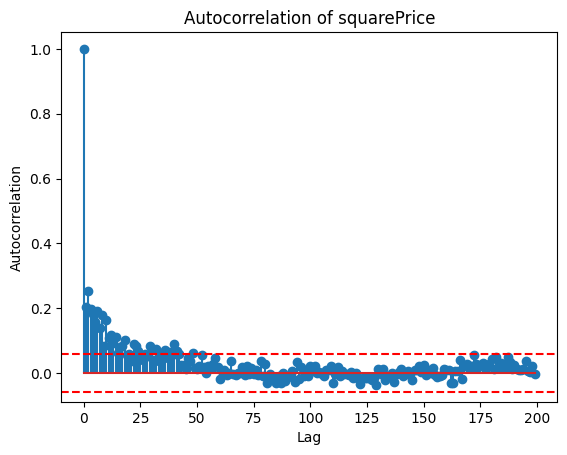

In [78]:
## b

def AutoCorrelationFunction(column , dataFrame, lags, plot = True):
    returnValues = np.zeros(lags)

    for i in range(lags):
        original = dataFrame.iloc[0:-(1+i)][column].to_numpy()
        lagged = dataFrame.iloc[i:-1][column].to_numpy()
        meanValue = np.mean(original)
        variance = np.var(original)
        
        returnValues[i] = (1/len(original) * ((original - meanValue) @ (lagged - meanValue).T) )/variance

    if plot:
        conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(original))
        fig, ax = plt.subplots()
        ax.stem(returnValues)
        ax.axhline(y=conficenceBound, color='r', linestyle='--')
        ax.axhline(y=-conficenceBound, color='r', linestyle='--')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        ax.set_title('Autocorrelation of ' + column )
        plt.show()

        #plt.stem(returnValues)
    
    return returnValues

## Log Returns 
returnAutocorrelation = AutoCorrelationFunction('logReturns', estimationPeriod, 200, plot = True )
## Squared returns
squareReturnAutocorrelation = AutoCorrelationFunction('squarePrice', estimationPeriod, 200, plot = True )

C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\2253398994.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estimationPeriod.loc[:, 'GarchVolatility'] = GARCHVolatilityEstimator(estimationPeriod, omega, alpha, beta)
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\2253398994.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estimationPeriod.loc[:, 'Residuals'] = estimationPeriod['logReturns'].to_numpy() / estimationPeriod['GarchVolatility'].to_numpy()
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24

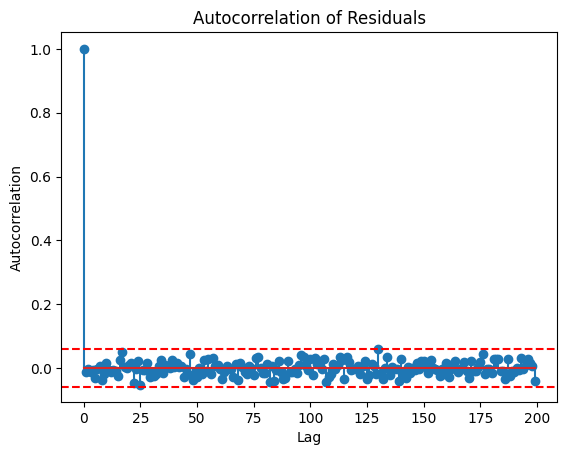

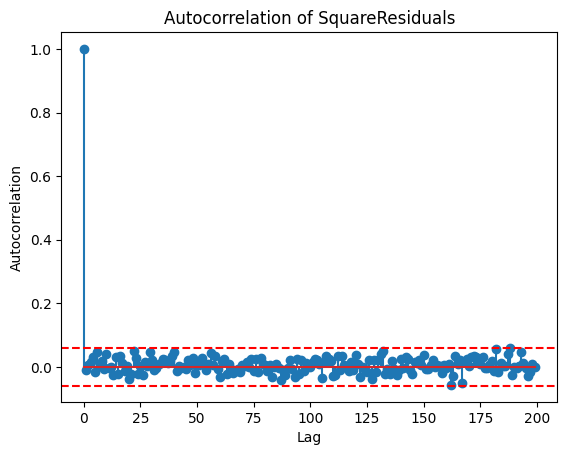

In [79]:
## c

def GARCHVolatilityEstimator(dataFrame, omega, alpha, beta):
    volatilityEstimateGARCH = np.zeros(dataFrame.shape[0])
    initialVolatility = np.sqrt(np.mean(dataFrame['squarePrice']))
    volatilityEstimateGARCH[0] = initialVolatility 

    for i in range(1, len(volatilityEstimateGARCH)):  # Start from 1 to avoid reassigning the first value
        volatilityEstimateGARCH[i] = np.sqrt(omega + alpha * dataFrame.iloc[i]['squarePrice'] + beta * (initialVolatility ** 2))
        initialVolatility = volatilityEstimateGARCH[i]

    return volatilityEstimateGARCH

# Use .loc to avoid SettingWithCopyWarning
estimationPeriod.loc[:, 'GarchVolatility'] = GARCHVolatilityEstimator(estimationPeriod, omega, alpha, beta)
estimationPeriod.loc[:, 'Residuals'] = estimationPeriod['logReturns'].to_numpy() / estimationPeriod['GarchVolatility'].to_numpy()
estimationPeriod.loc[:, 'SquareResiduals'] = estimationPeriod['Residuals'].to_numpy() ** 2


## Residuals
ResidualAutocorrelation = AutoCorrelationFunction('Residuals', estimationPeriod.iloc[100:], 200, plot = True )
## Squared residuals
squareResidualAutocorrelation = AutoCorrelationFunction('SquareResiduals', estimationPeriod.iloc[100:], 200, plot = True )


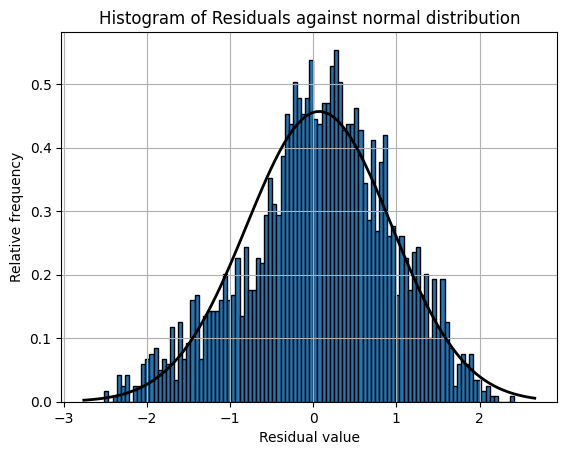

In [82]:
## d
estimationPeriod.iloc[100:]['Residuals'].hist(bins = 100, edgecolor = 'black', density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(estimationPeriod.iloc[100:]['Residuals']), np.std(estimationPeriod.iloc[100:]['Residuals']))
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogram of ' + 'Residuals against normal distribution')
plt.xlabel('Residual value')
plt.ylabel('Relative frequency')

plt.show()


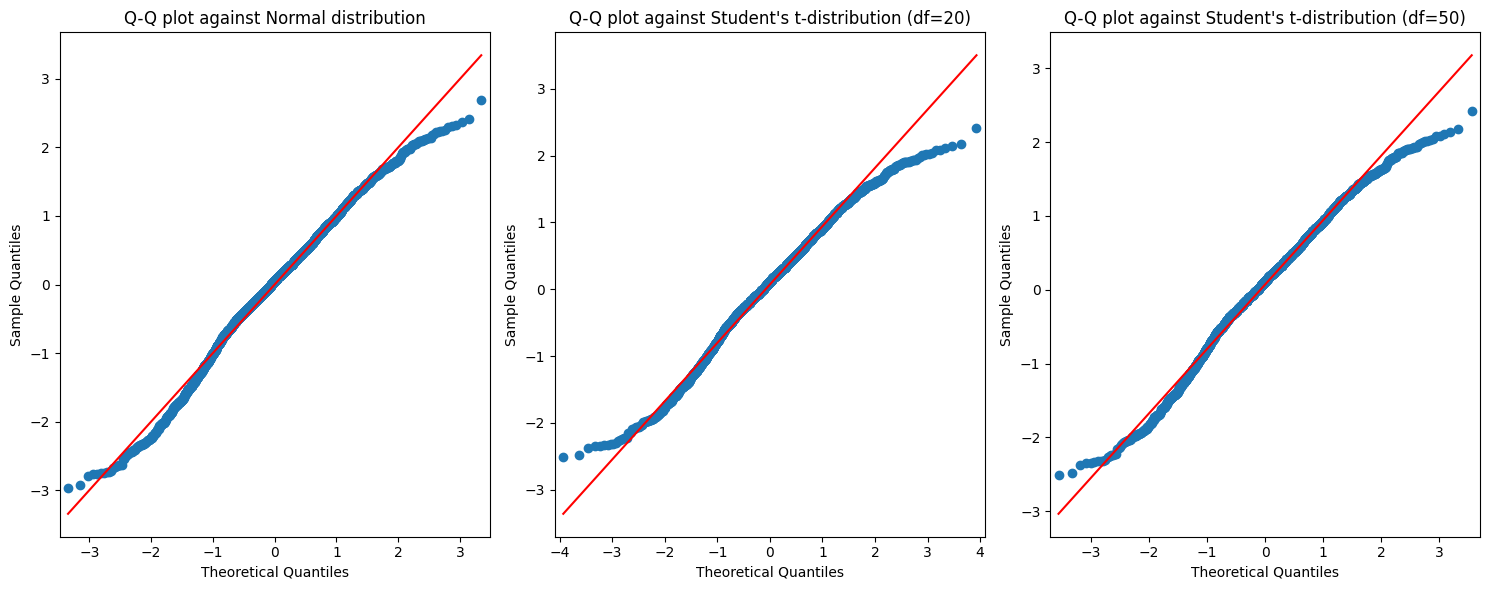

In [83]:
## e)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))

sm.qqplot(estimationPeriod['Residuals'].iloc[100:].values, line ='s', ax = ax[0], fit = True)
ax[0].set_title('Q-Q plot against Normal distribution')

# Q-Q plot against Student's t-distribution with df=3
sm.qqplot(estimationPeriod['Residuals'].iloc[100:].values, dist=t, distargs=(20,), line='s', ax=ax[1])
ax[1].set_title("Q-Q plot against Student's t-distribution (df=20)")

sm.qqplot(estimationPeriod['Residuals'].iloc[100:].values, dist=t, distargs=(50,), line='s', ax=ax[2])
ax[2].set_title("Q-Q plot against Student's t-distribution (df=50)")

plt.tight_layout()


## 4. VaR forecasts using historical simulation

Use backtesting to compare daily VaR98%-forecasts for the period 2020-01-01 -> 2023-12-31 using two versions
of basic historical simulation with rolling estimation windows of length 500 and 1000 days respectively.
- a) Plot the VaR-forecasts in the same plot as the (negative) returns
- b) Calculate the violation ratios for the different methods and give the number of violations for each
method in the report

*Discussion: What are the pros and cons of using these methods?*

C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\3886017535.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['negativeLogReturns']= -plotDf['logReturns'].values
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\3886017535.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['VaR-500'] = VaR[:,0]
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\3886017535.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

<Axes: title={'center': 'VaR estimates over time'}, xlabel='Time', ylabel='Loss'>

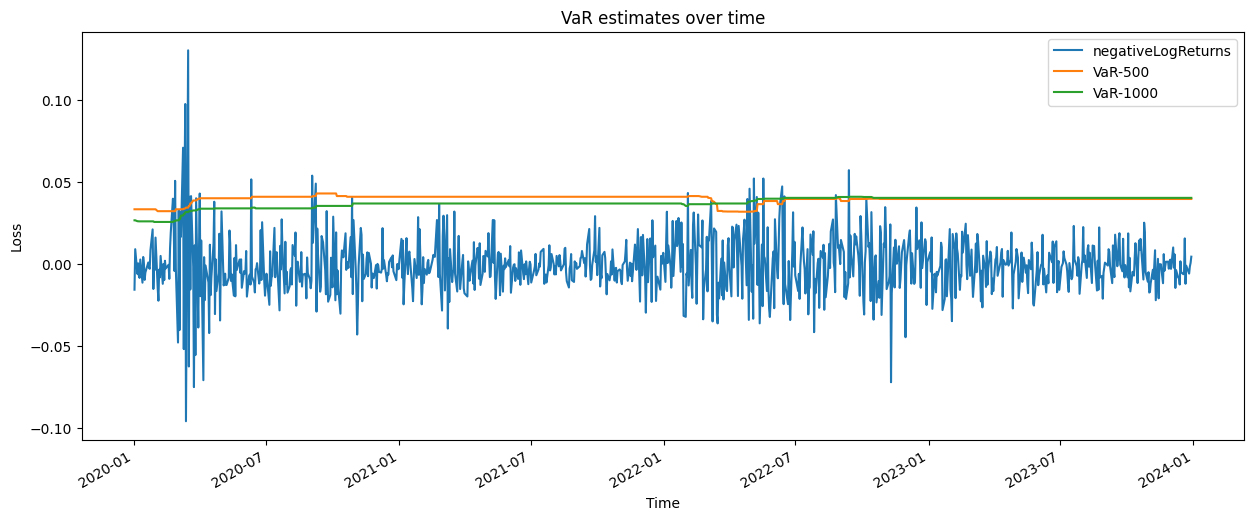

In [84]:
confidence = 0.98
riskPeriods = 1 # Number of days
estimationPeriodDays = [500,1000]
lengthOfData = len(price)

VaR = np.zeros((1006, 2))

for j in range(len(estimationPeriodDays)):
    splitIndex = lengthOfData - 1006 - estimationPeriodDays[j]
    VaRCalculationPeriod = price.iloc[splitIndex:]

    for i in range(len(VaRCalculationPeriod) - estimationPeriodDays[j]):    
        HMinus = -VaRCalculationPeriod.iloc[i:i+estimationPeriodDays[j]]['logReturns'].values
        VaR[i,j] = np.quantile(HMinus,confidence)

### Plotting
plotDf = price.iloc[-1006:]
plotDf['negativeLogReturns']= -plotDf['logReturns'].values
plotDf['VaR-500'] = VaR[:,0]
plotDf['VaR-1000'] = VaR[:,1]

plotDf[['negativeLogReturns', 'VaR-500', 'VaR-1000']].plot(title = 'VaR estimates over time', ylabel='Loss' ,xlabel='Time', figsize=(15,6))

In [85]:
plotDf['exceedance-500'] = (plotDf['VaR-500'].values < plotDf['negativeLogReturns'].values).astype(int)
plotDf['exceedance-1000'] = (plotDf['VaR-1000'].values < plotDf['negativeLogReturns'].values).astype(int)

ratio500 = np.mean(plotDf['exceedance-500'].values)
ratio1000 = np.mean(plotDf['exceedance-1000'].values)

violationRatio500 = ratio500/(1-confidence)
violationRatio1000 = ratio1000/(1-confidence)

print('------------------------------------------------------------')
print(f'Violation ratio for 500 days is: {violationRatio500}' )

print(f'Violation ratio for 1000 days is: {violationRatio1000}' )
print('------------------------------------------------------------')


------------------------------------------------------------
Violation ratio for 500 days is: 1.1928429423459233
Violation ratio for 1000 days is: 1.4413518886679908
------------------------------------------------------------


C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\2455847392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['exceedance-500'] = (plotDf['VaR-500'].values < plotDf['negativeLogReturns'].values).astype(int)
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\2455847392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['exceedance-1000'] = (plotDf['VaR-1000'].values < plotDf['negativeLogReturns'].values).astype(int)


## 5. VaR forecasts using GARCH and FHS

Repeat the backtest procedure in 4 but now based on the GARCH-model from 2. The two models to backtest
are:
- GARCH with the assumption of normally distributed conditional returns
- One-period filtered historical simulation (FHS)

You do not need to recalibrate the GARCH-model during the backtest period.
- a) Plot the VaR-forecasts in the same plot as in 4
- b) Calculate the violation ratios

*Discussion: What are the pros and cons of using these methods?*

In [86]:

def GARCHVolatilityEstimator(dataFrame, omega, alpha, beta, initialVolatility):
    volatilityEstimateGARCH = np.zeros(dataFrame.shape[0])
    volatilityEstimateGARCH[0] = initialVolatility 

    for i in range(1, len(volatilityEstimateGARCH)):  # Start from 1 to avoid reassigning the first value
        volatilityEstimateGARCH[i] = np.sqrt(omega + alpha * dataFrame.iloc[i]['squarePrice'] + beta * (initialVolatility ** 2))
        initialVolatility = volatilityEstimateGARCH[i]

    return volatilityEstimateGARCH


C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\404510973.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['VolatilityEstimate'] = price.iloc[-1006:]['VolatilityEstimate']
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\404510973.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['VaR-500-Normal'] = NormalVaR[:,0]
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\404510973.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

<Axes: title={'center': 'VaR estimates over time'}, xlabel='Time', ylabel='Loss'>

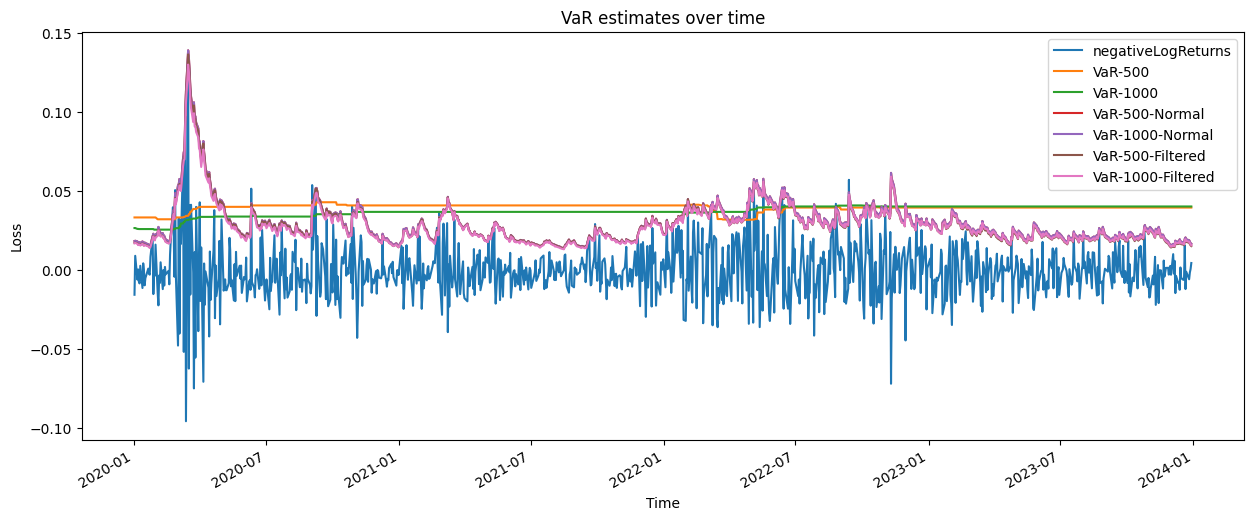

In [87]:
confidence = 0.98
riskPeriods = 1 # Number of days
estimationPeriodDays = [500,1000]
lengthOfData = len(price)

NormalVaR = np.zeros((1006, 2))
FilteredVaR = np.zeros((1006, 2))

initialVolatility = np.sqrt(np.mean(estimationPeriod['squarePrice']))

price['VolatilityEstimate'] = GARCHVolatilityEstimator(price, omega, alpha, beta, initialVolatility)

for j in range(len(estimationPeriodDays)):
    splitIndex = lengthOfData - 1006 - estimationPeriodDays[j]
    VaRCalculationPeriod = price.iloc[splitIndex:]

    for i in range(len(VaRCalculationPeriod) - estimationPeriodDays[j]):    
        ZMinus = -(VaRCalculationPeriod.iloc[i:i+estimationPeriodDays[j]]['logReturns'].values / VaRCalculationPeriod.iloc[i:i+estimationPeriodDays[j]]['VolatilityEstimate'].values )

        FilteredVaR[i,j] = np.quantile(ZMinus,confidence)*VaRCalculationPeriod.iloc[i+estimationPeriodDays[j]]['VolatilityEstimate']
        NormalVaR[i,j] = norm.ppf(confidence)*VaRCalculationPeriod.iloc[i+estimationPeriodDays[j]]['VolatilityEstimate']



### Plotting
# plotDf = price.iloc[-1006:]
# plotDf['negativeLogReturns']= -plotDf['logReturns'].values

plotDf['VolatilityEstimate'] = price.iloc[-1006:]['VolatilityEstimate']

plotDf['VaR-500-Normal'] = NormalVaR[:,0]
plotDf['VaR-1000-Normal'] = NormalVaR[:,1]
plotDf['VaR-500-Filtered'] = FilteredVaR[:,0]
plotDf['VaR-1000-Filtered'] = FilteredVaR[:,1]

plotDf[['negativeLogReturns', 'VaR-500', 'VaR-1000', 'VaR-500-Normal','VaR-1000-Normal', 'VaR-500-Filtered','VaR-1000-Filtered' ]].plot(title = 'VaR estimates over time', ylabel='Loss' ,xlabel='Time' , figsize=(15,6))


In [88]:
plotDf['exceedance-500-Normal'] = (plotDf['VaR-500-Normal'].values < plotDf['negativeLogReturns'].values).astype(int)
plotDf['exceedance-1000-Normal'] = (plotDf['VaR-1000-Normal'].values < plotDf['negativeLogReturns'].values).astype(int)

plotDf['exceedance-500-Filtered'] = (plotDf['VaR-500-Filtered'].values < plotDf['negativeLogReturns'].values).astype(int)
plotDf['exceedance-1000-Filtered'] = (plotDf['VaR-1000-Filtered'].values < plotDf['negativeLogReturns'].values).astype(int)

ratio500Normal = np.mean(plotDf['exceedance-500-Normal'].values)
ratio1000Normal = np.mean(plotDf['exceedance-1000-Normal'].values)

ratio500Filtered = np.mean(plotDf['exceedance-500-Filtered'].values)
ratio1000Filtered = np.mean(plotDf['exceedance-1000-Filtered'].values)

violationRatio500Normal = ratio500Normal/(1-confidence)
violationRatio1000Normal = ratio1000Normal/(1-confidence)

violationRatio500Filtered = ratio500Filtered/(1-confidence)
violationRatio1000Filtered = ratio1000Filtered/(1-confidence)

print('------------------------------------------------------------')
print(f'Violation ratio for 500 days Normal VaR is: {violationRatio500Normal}' )

print(f'Violation ratio for 1000 days Normal VaR is: {violationRatio1000Normal}' )
print('------------------------------------------------------------')

print('------------------------------------------------------------')
print(f'Violation ratio for 500 days Filtered VaR is: {violationRatio500Filtered}' )

print(f'Violation ratio for 1000 days Filtered VaR is: {violationRatio1000Filtered}' )
print('------------------------------------------------------------')


------------------------------------------------------------
Violation ratio for 500 days Normal VaR is: 0.5467196819085482
Violation ratio for 1000 days Normal VaR is: 0.5467196819085482
------------------------------------------------------------
------------------------------------------------------------
Violation ratio for 500 days Filtered VaR is: 0.9940357852882695
Violation ratio for 1000 days Filtered VaR is: 0.9940357852882695
------------------------------------------------------------


C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\3433929352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['exceedance-500-Normal'] = (plotDf['VaR-500-Normal'].values < plotDf['negativeLogReturns'].values).astype(int)
C:\Users\Bolli\AppData\Local\Temp\ipykernel_24860\3433929352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf['exceedance-1000-Normal'] = (plotDf['VaR-1000-Normal'].values < plotDf['negativeLogReturns'].values).astype(int)
C:\Users\Bolli\AppData\Local\Temp\ipykernel_2486